Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing all the important libraries

In [1]:
#Importing the required libraries.

import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import PIL
from tensorflow import keras
from tensorflow.keras import layers, optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, BatchNormalization, Conv2D, Dense, Dropout, Flatten, MaxPool2D
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

In [2]:
#Mounting the google drive.
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
#To unzip the dataset.

import zipfile

with zipfile.ZipFile("/content/gdrive/MyDrive/CNN_Assignment/CNN_assignment.zip", "r") as zf:
    zf.extractall("/content/gdrive/MyDrive/CNN_Assignment/")

In [4]:
# Defining the path for train and test images
data_dir_train = pathlib.Path("/content/gdrive/MyDrive/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path('/content/gdrive/MyDrive/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [5]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [6]:
batch_size = 32
img_height = 180
img_width = 180
img_size = (img_height, img_width)

Use 80% of the images for training, and 20% for validation.

In [7]:
# Creating the training dataset

train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train, seed = 123,
                                                                validation_split = 0.2, shuffle = True,
                                                               batch_size = batch_size,
                                                               image_size = img_size,
                                                               label_mode='categorical',
                                                               subset = "training")

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [8]:
# Creating the validation dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train, seed = 123,
                                                                validation_split = 0.2, shuffle = True,
                                                               batch_size = batch_size,
                                                               image_size = img_size,
                                                                label_mode='categorical',
                                                               subset = "validation")

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [9]:
# List out all the classes of skin cancer and store them in a list.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


#### Visualizing one instance of all the nine classes present in the dataset.

In [10]:
def plot_images_from_dataset(dataset, class_names, num_images = 12):

    """Function to plot the images from the dataset."""
    plt.figure(figsize = (20, 10), dpi = 100)

    for images, labels in dataset:
        for i in range(12):
            ax = plt.subplot(3, 4, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            class_index = np.argmax(labels[i])
            plt.title(class_names[class_index])
            plt.axis("off")
            num_images -= 1
            if num_images == 0:
                break

        if num_images == 0:
            break

    plt.tight_layout()
    plt.show()

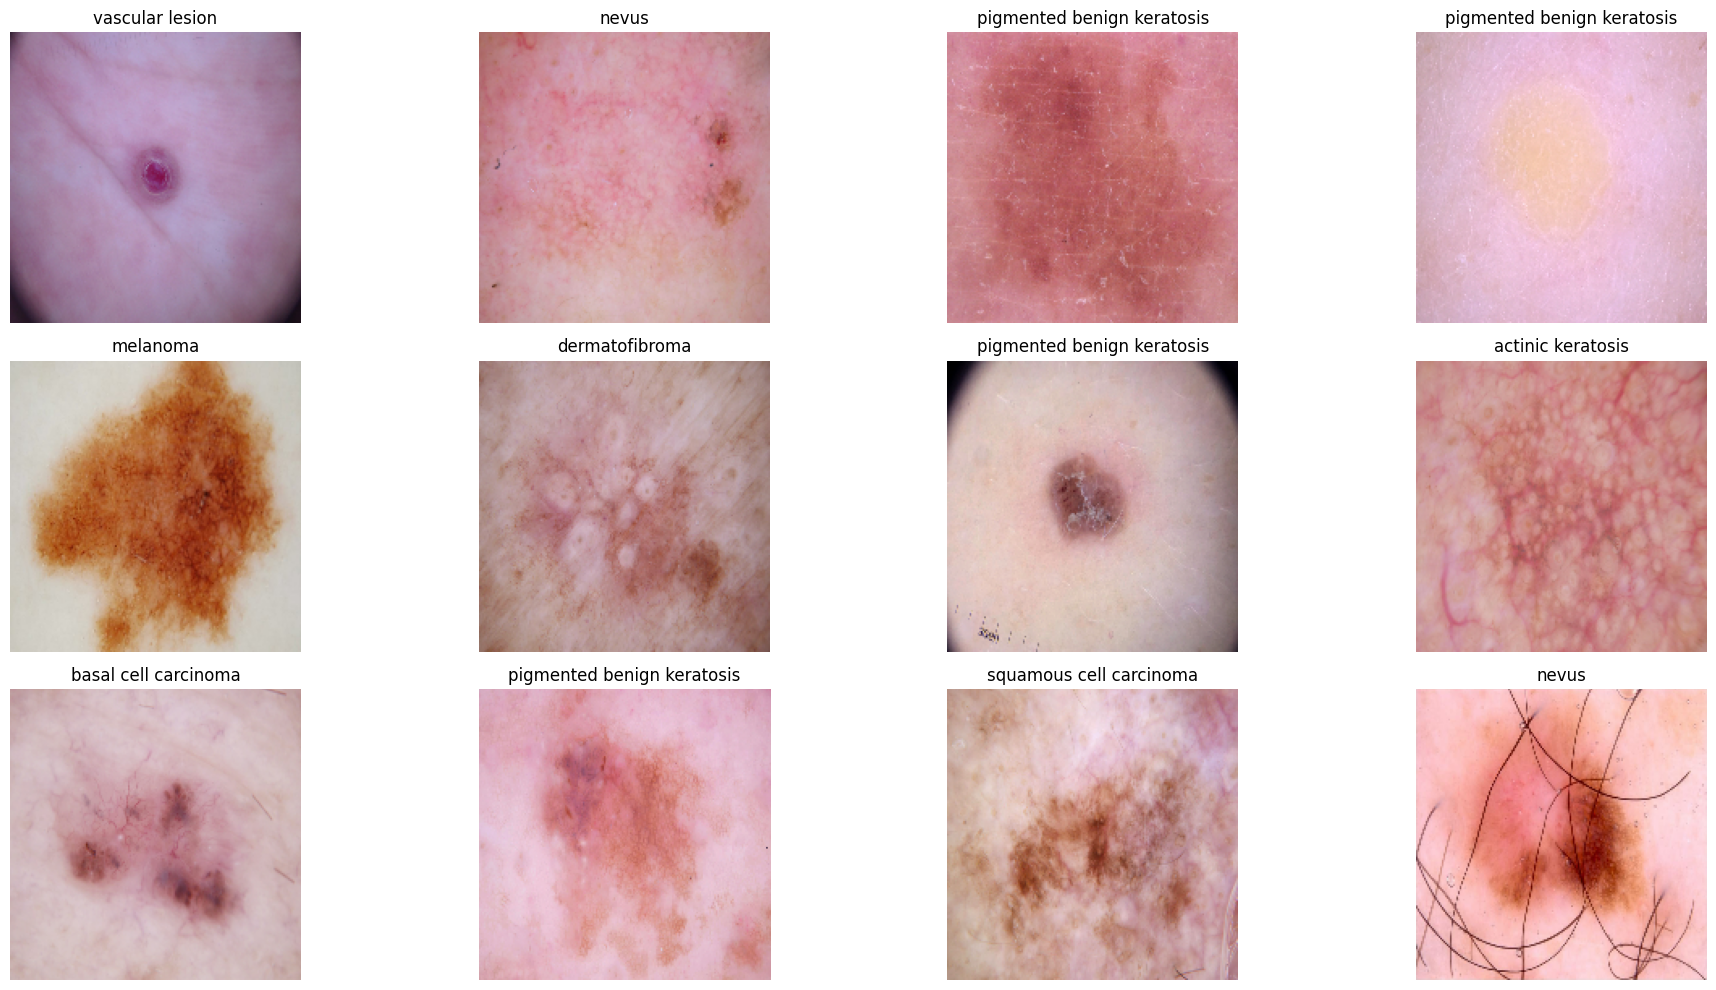

In [11]:
plot_images_from_dataset(train_ds, class_names)

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [12]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Creating a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [13]:
#Defining the input shape to the network.
input_shape = (180, 180, 3)

In [14]:
### Creating a NN architecture.
model = Sequential()
model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape = input_shape))

model.add(Conv2D(32, kernel_size = (3,3), activation = "relu"))
#To normalize activations.
model.add(BatchNormalization())
#To reduce spatial dimensions.
model.add(MaxPool2D())

model.add(Conv2D(64, kernel_size = (3,3), activation = "relu"))
model.add(BatchNormalization())
model.add(MaxPool2D())

model.add(Conv2D(128, kernel_size = (3,3), activation = "relu"))
model.add(BatchNormalization())
model.add(MaxPool2D())

model.add(Conv2D(128, kernel_size = (3,3), activation = "relu"))
model.add(BatchNormalization())
model.add(MaxPool2D())

model.add(Conv2D(256, kernel_size = (3,3), activation = "relu"))
model.add(BatchNormalization())
model.add(MaxPool2D())

#Flattening the output for dense layer(s).
model.add(Flatten())

model.add(Dense(256, activation = "relu"))
model.add(BatchNormalization())

#Ouput layer with number of units equal to the number of classes.
model.add(Dense(len(class_names), activation = "softmax"))

### Compile the model
Choose an appropirate optimiser and loss function for model training

In [15]:
model.compile(optimizer = optimizers.Adam(),
              loss = "categorical_crossentropy",
              metrics=['accuracy'])

In [16]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 178, 178, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 89, 89, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 batch_normalization_1 (Bat  (None, 87, 87, 64)        2

### Train the model

In [17]:
#Training the model for 20 epochs.
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 37s 141ms/step - loss: 1.7868 - accuracy: 0.4397 - val_loss: 2.8468 - val_accuracy: 0.2058
Epoch 2/20
56/56 [==============================] - 3s 49ms/step - loss: 1.2388 - accuracy: 0.5692 - val_loss: 2.7926 - val_accuracy: 0.1499
Epoch 3/20
56/56 [==============================] - 3s 49ms/step - loss: 1.1079 - accuracy: 0.6077 - val_loss: 3.6454 - val_accuracy: 0.1499
Epoch 4/20
56/56 [==============================] - 3s 47ms/step - loss: 0.9564 - accuracy: 0.6618 - val_loss: 4.0503 - val_accuracy: 0.2595
Epoch 5/20
56/56 [==============================] - 3s 46ms/step - loss: 0.8577 - accuracy: 0.6925 - val_loss: 3.9266 - val_accuracy: 0.1588
Epoch 6/20
56/56 [==============================] - 3s 46ms/step - loss: 0.6694 - accuracy: 0.7651 - val_loss: 2.7493 - val_accuracy: 0.2170
Epoch 7/20
56/56 [==============================] - 3s 53ms/step - loss: 0.5420 - accuracy: 0.8080 - val_loss: 4.1317 - val_accuracy: 0.2036
Epoch 8/20


### Visualizing training results

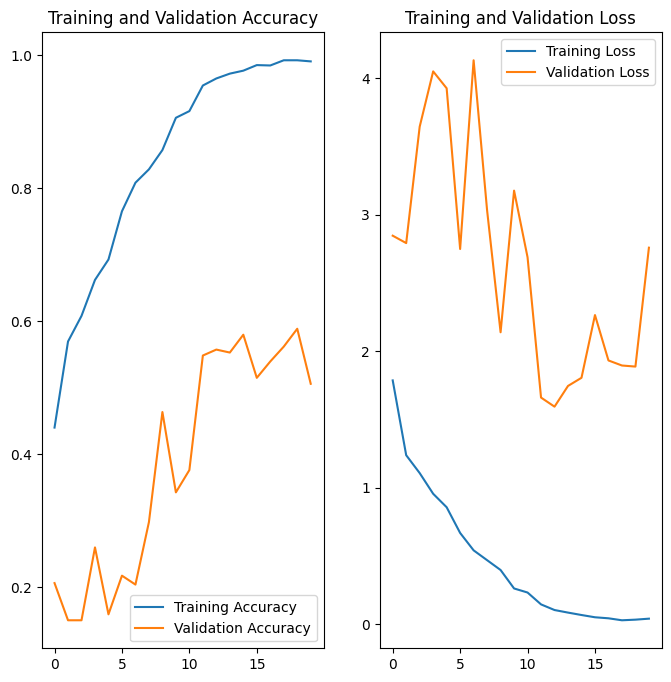

In [18]:
#Plotting the traning and validation accuracy and loss across epochs.

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

- Takeaways:
    - Severe overfitting, even though the model is able to learn well on the training data, the model performs poorly on the validation data, indicating the model is not suitable to perform predictions on unseen data.

In [19]:
# Define image data augmentation parameters
img_datagen = ImageDataGenerator(
    rotation_range = 10,
    zoom_range = 0.1,
    horizontal_flip = False,
    vertical_flip = False,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
)


# Create data generators for training and validation
new_train_ds = img_datagen.flow_from_directory(
    data_dir_train,
    target_size=img_size,
    classes=class_names,
    batch_size = batch_size,
    seed = 123
)

new_val_ds = img_datagen.flow_from_directory(
    data_dir_test,
    target_size=img_size,
    classes=class_names,
    batch_size = batch_size,
    seed = 123
)

Found 2239 images belonging to 9 classes.
Found 118 images belonging to 9 classes.


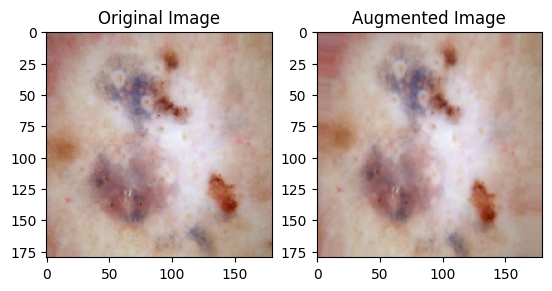

In [20]:
# Visualizing the augmented image.
augmented_images, _ = new_train_ds.next()
original_image = augmented_images[0]

# Plot the original image
plt.subplot(1, 2, 1)
plt.imshow(image.array_to_img(original_image))
plt.title('Original Image')

# Plot the augmented image
augmented_image = img_datagen.random_transform(original_image)
plt.subplot(1, 2, 2)
plt.imshow(image.array_to_img(augmented_image))
plt.title('Augmented Image')

plt.show()

### Create the model, compile and train the model on the augmented data from the ImageDataGenerator.


In [21]:
input_shape = (180, 180, 3)

model = Sequential()
model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape = input_shape))

model.add(Conv2D(32, kernel_size = (3,3), activation = "relu"))
model.add(BatchNormalization())
model.add(MaxPool2D())

model.add(Conv2D(64, kernel_size = (3,3), activation = "relu"))
model.add(BatchNormalization())
model.add(MaxPool2D())

model.add(Conv2D(128, kernel_size = (3,3), activation = "relu"))
model.add(BatchNormalization())
model.add(MaxPool2D())

model.add(Conv2D(128, kernel_size = (3,3), activation = "relu"))
model.add(BatchNormalization())
model.add(MaxPool2D())

model.add(Conv2D(256, kernel_size = (3,3), activation = "relu"))
model.add(BatchNormalization())
model.add(MaxPool2D())

model.add(Flatten())

model.add(Dense(256, activation = "relu"))
model.add(BatchNormalization())

model.add(Dense(len(class_names), activation = "softmax"))

### Compiling the model

In [22]:
model.compile(optimizer = optimizers.Adam(),
              loss = "categorical_crossentropy",
              metrics=['accuracy'])

# Using the ReduceLRonPlateau to reduce learning rate as the minima is being approached
lr_reduce = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.05, min_lr = 0.00001, patience = 3)

### Training the model

In [23]:
epochs = 20
history = model.fit(
  new_train_ds,
  validation_data=new_val_ds,
  epochs=epochs, callbacks = [lr_reduce]
)

Epoch 1/20
70/70 [==============================] - 58s 754ms/step - loss: 1.8315 - accuracy: 0.4194 - val_loss: 2.7877 - val_accuracy: 0.1356 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 54s 772ms/step - loss: 1.4005 - accuracy: 0.5127 - val_loss: 2.7890 - val_accuracy: 0.1356 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 50s 711ms/step - loss: 1.3489 - accuracy: 0.5150 - val_loss: 2.4751 - val_accuracy: 0.1525 - lr: 0.0010
Epoch 4/20
70/70 [==============================] - 50s 711ms/step - loss: 1.2757 - accuracy: 0.5351 - val_loss: 2.2971 - val_accuracy: 0.1949 - lr: 0.0010
Epoch 5/20
70/70 [==============================] - 49s 707ms/step - loss: 1.2450 - accuracy: 0.5480 - val_loss: 2.0239 - val_accuracy: 0.2458 - lr: 0.0010
Epoch 6/20
70/70 [==============================] - 50s 713ms/step - loss: 1.1928 - accuracy: 0.5659 - val_loss: 2.6964 - val_accuracy: 0.2458 - lr: 0.0010
Epoch 7/20
70/70 [==============================] - 50s 708ms/st

### Visualizing the results

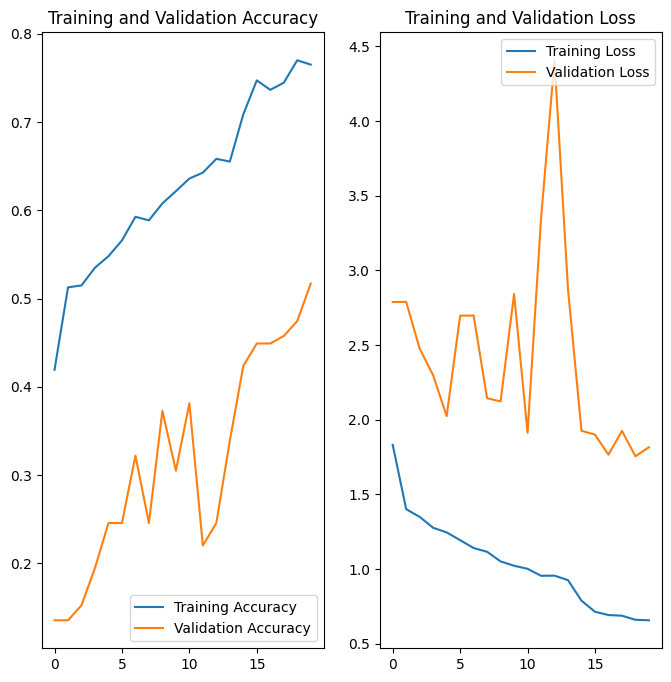

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

- Takeaway:
    - It is observed the ImageDataGenerator strategy has not worked well. The model is not able to learn well from the training data, although the overfitting is addressed to some extent. It may be an indication that either the model is too simple or more training epochs are needed to reach the acceptable training and validation accuracies.

#Finding class distributions.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

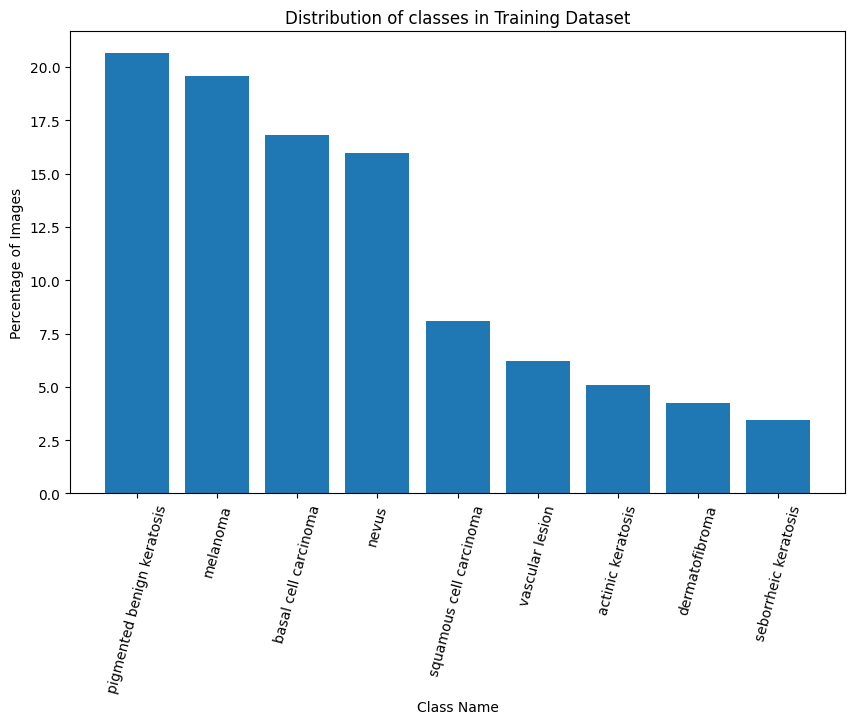

In [25]:
data_dir_train = '/content/gdrive/MyDrive/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/'

class_names = os.listdir(data_dir_train)

# Dictionary to store class distribution
class_distribution = {}

# Iterate through class directories and count the number of images in each class
total_images = 0
for class_name in class_names:
    class_path = os.path.join(data_dir_train, class_name)
    num_images = len(os.listdir(class_path))
    class_distribution[class_name] = num_images
    total_images += num_images

# Calculating the  percentages
class_percentages = {class_name: (num_images / total_images) * 100 for class_name, num_images in class_distribution.items()}
sorted_class_percentages = dict(sorted(class_percentages.items(), key=lambda item: item[1], reverse=True))

# Plotting the class distribution percentages.
plt.figure(figsize=(10, 6))
plt.bar(sorted_class_percentages.keys(), sorted_class_percentages.values())
plt.xlabel('Class Name')
plt.ylabel('Percentage of Images')
plt.xticks(rotation = 75)
plt.title('Distribution of classes in Training Dataset')
plt.show()

- Takeaways:
    - Pigmented Beningn Keratosis has the highest percentage of images (>20%).
    - Seborrheic Keratosis has the least percentage of images (~3.7%).
    - Pigemented Beningn Keratosis, Melanoma, Basal Cell Carcinoma, Nevus dominate in terms of the number of images (>15%).


#### Rectifying the class imbalance
#### **Context:** A python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) is used to add more samples across all classes so that none of the classes have very few samples.

In [26]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [27]:
path_to_training_dataset="/content/gdrive/MyDrive/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7B6FDA5B3FA0>: 100%|██████████| 500/500 [00:21<00:00, 23.76 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7B6FDA5EA950>: 100%|██████████| 500/500 [00:22<00:00, 22.23 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7B70E85FBD90>: 100%|██████████| 500/500 [00:18<00:00, 26.72 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=966x638 at 0x7B70580B0790>: 100%|██████████| 500/500 [01:17<00:00,  6.44 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=2048x1536 at 0x7B70E85FBD90>: 100%|██████████| 500/500 [01:17<00:00,  6.49 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7B70406270D0>: 100%|██████████| 500/500 [00:19<00:00, 25.99 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7B70580B1390>: 100%|██████████| 500/500 [00:37<00:00, 13.41 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7B70407AE410>: 100%|██████████| 500/500 [00:18<00:00, 26.77 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7B7040778130>: 100%|██████████| 500/500 [00:18<00:00, 27.52 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [29]:
from pathlib import Path
image_count_train = len(list(Path(data_dir_train).glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [30]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list[:5]

['/content/gdrive/MyDrive/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0030825.jpg_4cf90ccf-59d4-457c-b899-e527e94ea822.jpg',
 '/content/gdrive/MyDrive/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026040.jpg_a4f2f44d-8b19-446b-bc61-0c4491ea12ab.jpg',
 '/content/gdrive/MyDrive/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0033811.jpg_1da09df4-bc68-40f1-acc2-5b8b04d6233a.jpg',
 '/content/gdrive/MyDrive/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0030730.jpg_72d56ecb-ca63-4b2f-a17a-f2b3d3418c33.jpg',
 '/content/gdrive/MyDrive/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic

In [31]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new[:5]

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis']

In [32]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [33]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = df2.copy()

In [34]:
new_df['Label'].value_counts()

actinic keratosis             500
basal cell carcinoma          500
dermatofibroma                500
melanoma                      500
nevus                         500
pigmented benign keratosis    500
seborrheic keratosis          500
squamous cell carcinoma       500
vascular lesion               500
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

### Training the model on the data created using Augmentor

In [35]:
batch_size = 32
img_height = 180
img_width = 180

### Creating the training dataset

In [36]:
data_dir_train="/content/gdrive/MyDrive/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  label_mode='categorical',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


### Creating the validation dataset

In [37]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  label_mode='categorical',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


### Creating the model.

In [38]:
input_shape = (180, 180, 3)

model = Sequential()
model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape = input_shape))

model.add(Conv2D(32, kernel_size = (3,3), activation = "relu"))
model.add(BatchNormalization())
model.add(MaxPool2D())

model.add(Conv2D(64, kernel_size = (3,3), activation = "relu"))
model.add(BatchNormalization())
model.add(MaxPool2D())

model.add(Conv2D(128, kernel_size = (3,3), activation = "relu"))
model.add(BatchNormalization())
model.add(MaxPool2D())

model.add(Conv2D(128, kernel_size = (3,3), activation = "relu"))
model.add(BatchNormalization())
model.add(MaxPool2D())

model.add(Conv2D(256, kernel_size = (3,3), activation = "relu"))
model.add(BatchNormalization())
model.add(MaxPool2D())

model.add(Flatten())

model.add(Dense(256, activation = "relu"))
model.add(BatchNormalization())

model.add(Dense(len(class_names), activation = "softmax"))

### Compiling the model.

In [39]:
model.compile(optimizer = optimizers.Adam(),
              loss = "categorical_crossentropy",
              metrics=['accuracy'])

lr_reduce = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.05, min_lr = 0.00001, patience = 3)

#Using early stopping to stop training when validation loss does not improve for 5 consecutive epochs.

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
)

### Training the model.


In [40]:
epochs = 50
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs, callbacks = [lr_reduce, early_stopping]
)

Epoch 1/50
169/169 [==============================] - 50s 262ms/step - loss: 1.5231 - accuracy: 0.4661 - val_loss: 2.8894 - val_accuracy: 0.0958 - lr: 0.0010
Epoch 2/50
169/169 [==============================] - 46s 260ms/step - loss: 1.0648 - accuracy: 0.6185 - val_loss: 2.7046 - val_accuracy: 0.2494 - lr: 0.0010
Epoch 3/50
169/169 [==============================] - 42s 240ms/step - loss: 0.8220 - accuracy: 0.6951 - val_loss: 1.3927 - val_accuracy: 0.4915 - lr: 0.0010
Epoch 4/50
169/169 [==============================] - 43s 245ms/step - loss: 0.6205 - accuracy: 0.7758 - val_loss: 1.0544 - val_accuracy: 0.6459 - lr: 0.0010
Epoch 5/50
169/169 [==============================] - 42s 242ms/step - loss: 0.4826 - accuracy: 0.8273 - val_loss: 0.9863 - val_accuracy: 0.6845 - lr: 0.0010
Epoch 6/50
169/169 [==============================] - 41s 237ms/step - loss: 0.4060 - accuracy: 0.8518 - val_loss: 2.3488 - val_accuracy: 0.3385 - lr: 0.0010
Epoch 7/50
169/169 [==============================] 

### Visualizing the model results

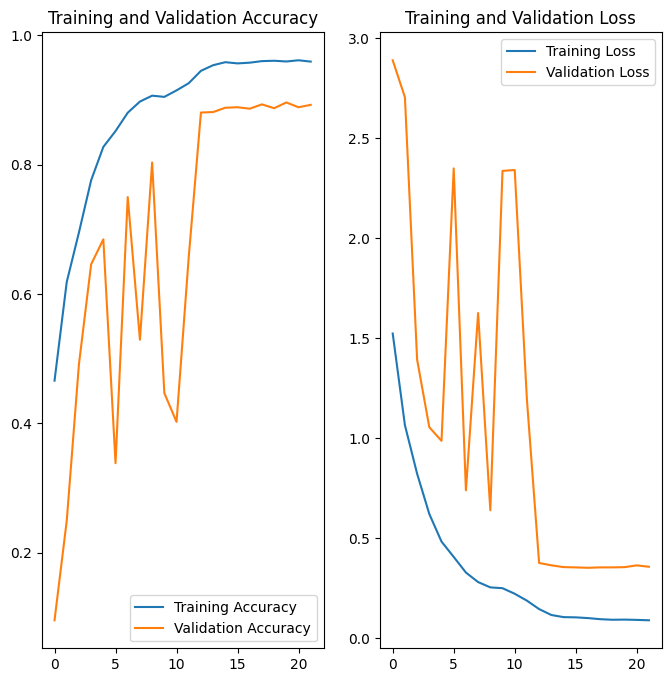

In [42]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(22)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

- Takeaways:
    - It can be seen that the model is perfoming very well on both training and validation datasets. Since Early Stopping was used, the optimal performance was reached at Epoch 22.
    - The overfitting is reduced to a very significant extent (even without using any Dropout layer) and the model performance on both training and validation datasets is acceptable.
    - It can also be observed that the model performance on the validation dataset is very stable after the Epoch 13.